# Predicting CMS Prevalence of Diabetes at County Level based on AHRQ Social Determinants of Health


__[GitHub: SocialHealthAI/CMS-CDC-SDOH](https://github.com/SocialHealthAI/CMS-CDC-SDOH)__

## Overview
Studies show a strong correlation between social determinants of health and mental/physical health. __[County Health Rankings, Relationships Between Determinant Factors
and Health Outcomes](https://www.ajpmonline.org/article/S0749-3797(15)00514-0/fulltext)__ provides a detailed analysis of social features correlated to premature death, low birth weight and poor mental/physical health.  

''<img src='./diabetes_ohio.png' title='Ohio Diabetes Prevalence and Social Vulnerability Index' />

The target for the models is the prevalence (percent) of diabetes based in a county.  Prevalence data is obtained from the Center of Medicare and Medicaid Services (CMS) diabetes claims.  The features used to predict the target are social determinants of health (SDOH).  SDOH features are obtained from the  Agency for Healthcare Research and Quality (AHRQ).

## Benefits
The models can be used in several ways:
- Ranking the important SDOH features for a county.
- Predicting the CMS prevalence based on SDOH features changes.
- Predicting the CMS prevalence when new AHRQ SDOH data is available.

# Set up Environment

In [218]:
%run ./environment/env1.ipynb

# Extract, transform and load data

## CMS Diabetes Claims
Call CMS Chronic Data notebook using year and disease parameters.

In [219]:
parm_CMSChronic_disease = 'Diabetes'
parm_CMSChronic_years = ['2015', '2016', '2017', '2018']
%run ./ETL/dataCMSChronic.ipynb
dfCMSChronicPrevalence = out_CMSChronic()

## Explore CMS Data
Show prevalence in sorted barchart for particular state.

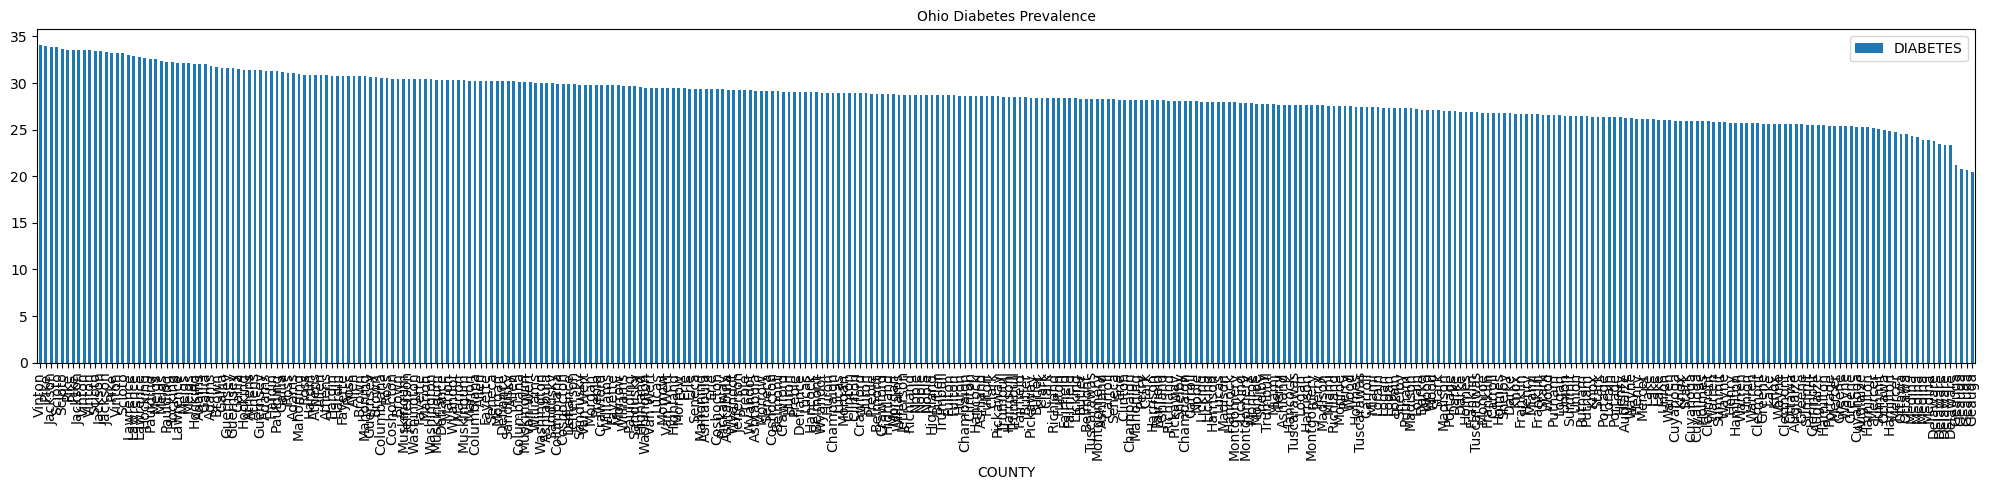

In [220]:
dfDisplay = dfCMSChronicPrevalence[dfCMSChronicPrevalence.STATE == 'Ohio']
dfDisplay= dfDisplay.sort_values('DIABETES',ascending=False)
dfDisplay.plot(x="COUNTY", y="DIABETES", kind="bar", figsize=(20,5))
plt.title("Ohio Diabetes Prevalence", fontsize=10)
plt.tight_layout()
plt.show()

## AHRQ Data
Call AHRQ SDOH Data notebook using year parameter.

In [221]:
parm_AHRQCountySDOH_years = ['2015', '2016', '2017', '2018']
# currently not including NOAAC - temperature by month
parm_AHRQCountySDOH_surveys = ["ACS", "AHA", "AMFAR", "CAF", "CCBP", "CDCSVI", "CEN", "CRDC", "EPAA", "FARA", "FEA", "HHC", "HIFLD", "HRSA", "MHSVI", "MP", "NCHS", "NEPHTN", "NHC", "NOAAS", "POS", "SAHIE", "SAIPE", "SEDA"]
parm_AHRQCountySDOH_questions = ["CDCW_INJURY_DTH_RATE", "CDCW_TRANSPORT_DTH_RATE", "CDCW_SELFHARM_DTH_RATE", "CDCW_ASSAULT_DTH_RATE", "CHR_TOT_MENTAL_PROV", "CHR_MENTAL_PROV_RATE", "CHR_SEGREG_BLACK", "CHR_PCT_ALCOHOL_DRIV_DEATH", "CHR_PCT_EXCESS_DRINK", "CHR_PCT_FOOD", "CHR_SEGREG_BLACK", "CHR_SEGREG_NON_WHITE"]
%run ./ETL/dataAHRQCountySDOH.ipynb
dfAHRQCountySDOH = out_AHRQCountySDOH()

## Explore AHRQ Data
Show correlations for food related SDOH.

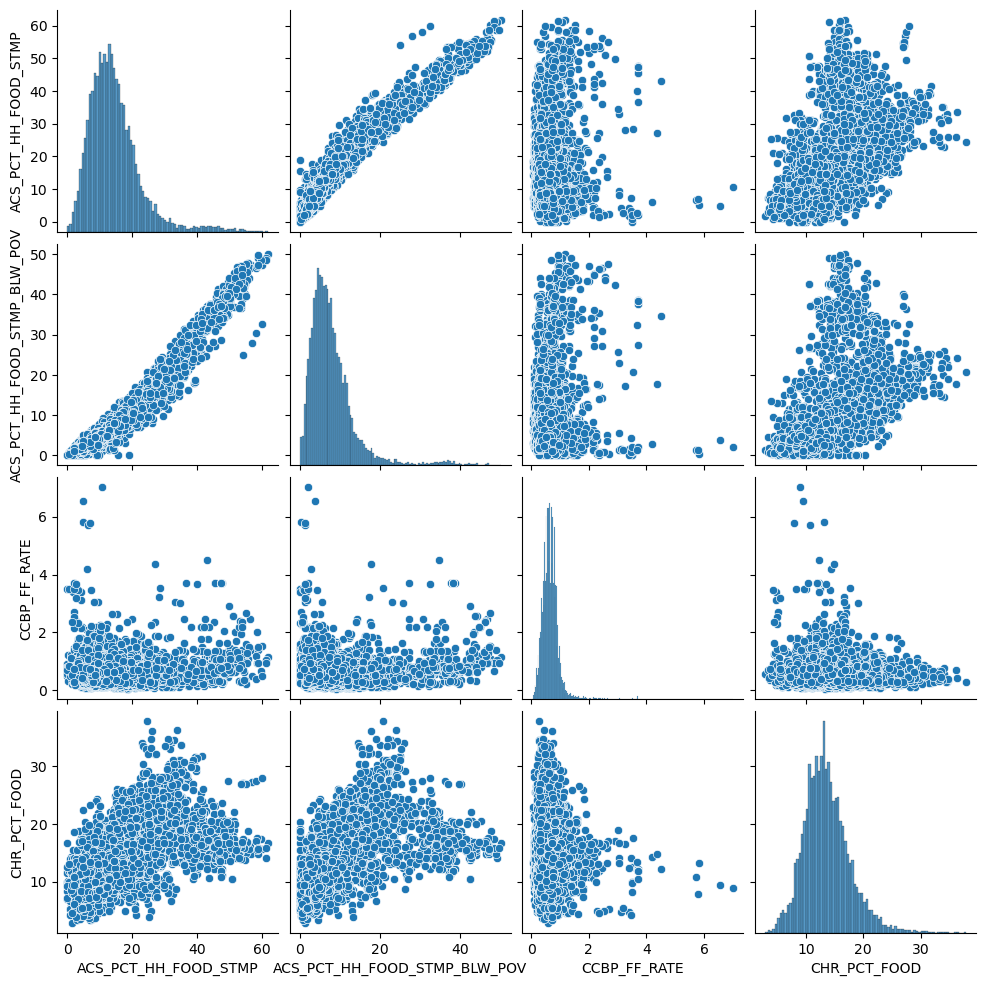

In [222]:
dfAHRQFood = dfAHRQCountySDOH[['STATE', 'COUNTY', 'ACS_PCT_HH_FOOD_STMP', 'ACS_PCT_HH_FOOD_STMP_BLW_POV' , 'CCBP_FF_RATE', 'CHR_PCT_FOOD']]
sns.pairplot(dfAHRQFood)

## Merge Data and Create Training, Test sets

In [223]:
dfMerged = pd.merge(dfAHRQCountySDOH, dfCMSChronicPrevalence, how='inner', left_on=['STATE','COUNTY', 'YEAR'], right_on = ['STATE','COUNTY', 'YEAR'])
dfMerged = dfMerged[dfMerged['YEAR'] < 2018]

X = dfMerged.drop(["DIABETES", "STATE", "COUNTY", "FIPS", "YEAR"], axis = 1)
Y = dfMerged["DIABETES"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y ,test_size = 0.2, random_state = 42)
pd.set_option('display.max_rows', 20)
dfMerged.isnull().sum()

STATE                    0
COUNTY                   0
YEAR                     0
ACS_TOT_POP_WT           0
ACS_TOT_POP_US_ABOVE1    0
                        ..
CHR_PCT_EXCESS_DRINK     0
CHR_PCT_FOOD             0
CHR_SEGREG_NON_WHITE     0
FIPS                     0
DIABETES                 0
Length: 486, dtype: int64

# Develop Models and Evaluate Performance

## Regression

## Random Forest
Random Forest can handle missing data.

In [224]:
# define the model
rf = RandomForestRegressor()
# fit the random forest model
rf.fit(X_train, Y_train)

# Coefficient of Determination
#rf.score(X_test,Y_test)

RandomForestRegressor()

R2 Score:  0.8758464552361354


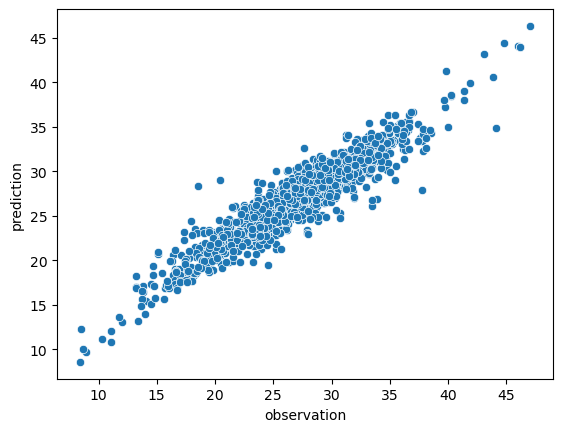

In [225]:
Y_pred = rf.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

### Feature importance

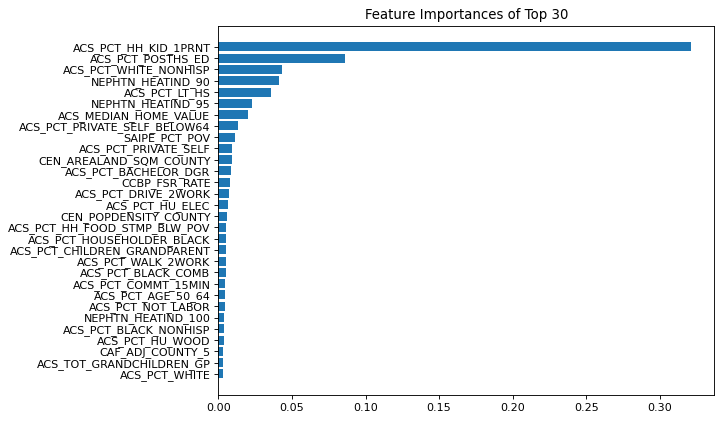

In [226]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
num_features = 30

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

plt.title('Feature Importances of Top 30')
plt.barh(range(num_features), importances[indices[-num_features:]], align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.show()

## Boosted Trees
XGBoost can handle missing data.

In [227]:
from sklearn.ensemble import GradientBoostingRegressor
xgb = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0).fit(X_train, Y_train)
#xgb.score(X_test, Y_test)

R2 Score:  0.7758061308180728


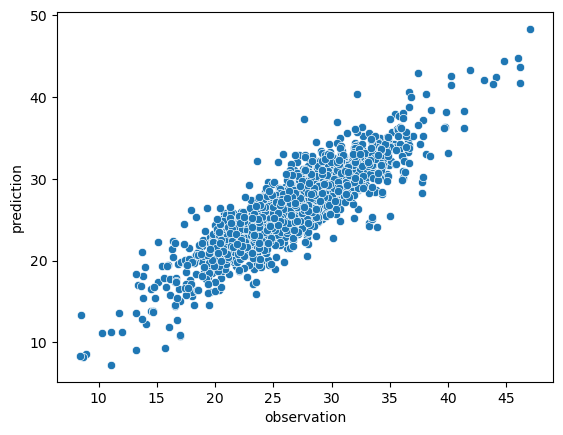

In [228]:
Y_pred = xgb.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

### Feature Importance

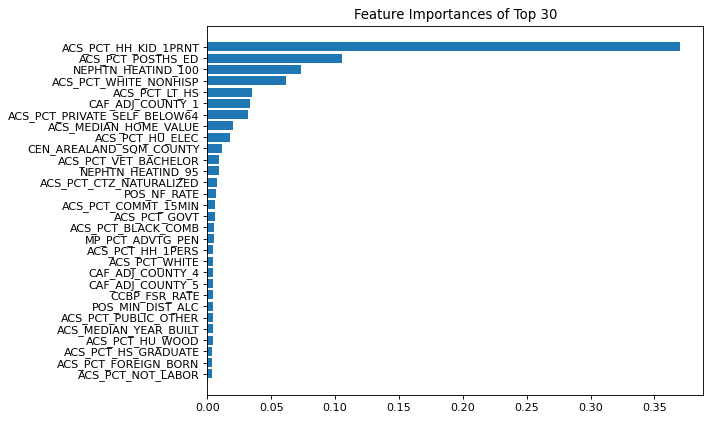

In [229]:
importances = xgb.feature_importances_
indices = np.argsort(importances)
num_features = 30

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

plt.title('Feature Importances of Top 30')
plt.barh(range(num_features), importances[indices[-num_features:]], align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.show()

# Evaluate performance future year

### Create test sets for future year

In [230]:
dfMerged = pd.merge(dfAHRQCountySDOH, dfCMSChronicPrevalence, how='inner', left_on=['STATE','COUNTY', 'YEAR'], right_on = ['STATE','COUNTY', 'YEAR'])
dfMerged = dfMerged[dfMerged['YEAR'] == 2018]

X_test = dfMerged.drop(["DIABETES", "STATE", "COUNTY", "FIPS", "YEAR"], axis = 1)
Y_test = dfMerged["DIABETES"]

## Regression

## Random Forest

R2 Score:  0.881758378092085


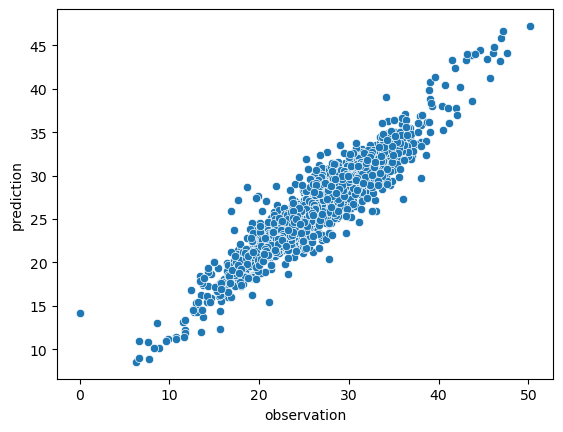

In [231]:
Y_pred = rf.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

## Boosted Trees

R2 Score:  0.7779235662093964


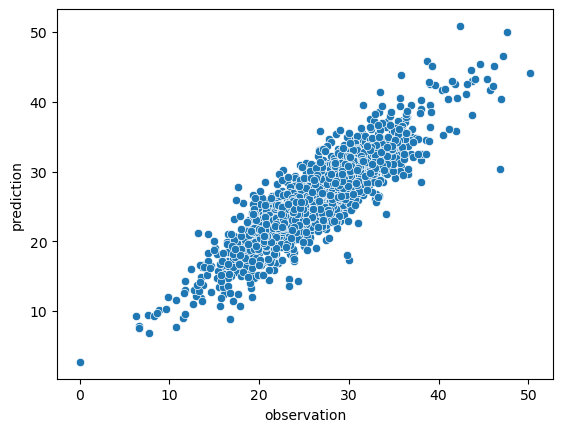

In [232]:
Y_pred = xgb.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

# Publish Models